DL network architecture for LeNet-5 with dropout and batchnorm2d and batchnorm1d

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class LeNet5(nn.Module):
    def __init__(self, num_of_classes, p): # 'p' probability of an element being zeroed out
        # Initialize the parent class (nn.Module)
        super(LeNet5, self).__init__()

        # Layer 1: Convolutional + BatchNorm2D  +  Pooling
        ''' we are using three channels as input (instead of 1) for some experiments that will be done later '''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        # Layer 2: Convolutional + BatchNorm2D + Pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)  # 14x14 -> 10x10
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 10x10 -> 5x5
        # Layer 3: Fully Connected + BatchNorm1D
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        # Layer 4: Fully Connected + BatchNorm1D
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        # Layer 5: Output Layer
        self.fc3 = nn.Linear(in_features=84, out_features=num_of_classes)
        # Dropout layers
        self.dropout = nn.Dropout(p)  # dropout layer defined in __init__

    def forward(self, x):
        # Layer 1: Conv2 -> BatchNorm -> Pooling -> Activation
        x = F.relu(self.pool1(self.bn1(self.conv1(x))))

        # Layer 2: Conv2 -> BatchNorm -> Pooling -> Activation
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 16 * 5 * 5)
        # Layer 3: Fully Connected + BatchNorm + Activation
        x = F.relu(self.bn3(self.fc1(x)))
        # Apply dropout after first FC layer
        x = self.dropout(x)
        # Layer 4: Fully Connected +  BatchNorm + Activation
        x = F.relu(self.bn4(self.fc2(x)))
        # Apply dropout after second FC layer
        x = self.dropout(x)
        # Layer 5: Fully Connected (Output)
        x = self.fc3(x)
        return x

# Creating a model object/instance
model = LeNet5(num_of_classes=10, p = 0.5)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Load the data from pytorch datasets and then split into training, validation, and testing.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np

transform_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels
    transforms.RandomRotation(30),        # Randomly rotate images by up to 30 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Randomly translate images
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
'''  Standard code from https://pytorch.org/vision/stable/datasets.html'''
# Load dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with a certain batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Visualize a few images from the batch and their labels

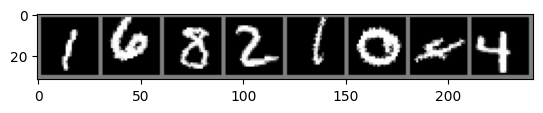

Labels: [1 6 8 2 1 0 4 4]


In [3]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    # Important when it is a Color (RGB) Image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
''' next(dataiter): Fetches the next batch from the train_loader'''
images, labels = next(dataiter)  # Use the built-in next() function


# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 8 images
print('Labels:', labels[:8].numpy())  # Print the corresponding labels

Define the device and optimizer function

In [4]:
import torch.optim as optim

'''  Decide if the calculations are perfomed by GPU or CPU  '''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''.to(device): moves tensors and models to the specified device (either GPU or CPU).
This ensures that all computations happen on the same device, avoiding errors or inefficiencies.'''
model = model.to(device)
# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
''' L2 Regularization adds a penalty proportional to the square of the magnitude
 of the weights to the loss function. Discourages the model from assigning
  too much importance to any individual feature by keeping the weights small.
 The larger the weight, the higher the penalty.'''
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)  # L2 regularization via weight_decay

Early Stopping

In [5]:
class EarlyStopping:
    """
    Initializes the early stopping mechanism.

    Args:
        patience (int): Number of epochs to wait for improvement.
        delta (float): Minimum change in validation loss to qualify as improvement.

    """
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_score = None  # Tracks the best loss (lower is better)
        self.early_stop = False  # Flag for early stopping
        self.counter = 0  # Counter for epochs without improvement
        self.best_loss = np.Inf  # Best loss starts as infinity

    ''' special method that allows us to use the object as if it were a function. '''
    def __call__(self, val_loss, model):
        """
        Training should be stopped early based on validation loss.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        score = -val_loss  # Loss is used as the score (lower is better, so we negate it)

        # If this is the first epoch or loss improved significantly
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            # No significant improvement (i..e, loss hasn't decreased enough)
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement in loss
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset the counter if loss improves

    def save_checkpoint(self, val_loss, model):
        """
        Save the model when validation loss improves.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        if val_loss < self.best_loss:  # We save if loss decreased
            self.best_loss = val_loss
            checkpoint_name = "checkpoint.pth"
            torch.save(model.state_dict(), checkpoint_name)
            print(f'Model saved as {checkpoint_name}')


Training and Validation both loss and accuracy

In [6]:
early_stopping = EarlyStopping(patience=5, delta=0.0001)


# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# number of epochs
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ''' torch.max(outputs, 1): The torch.max() function returns the maximum
        value of all elements in the tensor along a specified dimension.
         (_) is used for variables that we don't need to use   '''
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    # append the list
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    # append the list
    train_accuracies.append(train_accuracy)

    # .eval indicates that the model is used for prediction.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break


Epoch 1/50, Train Loss: 0.7591, Train Accuracy: 77.19%, Val Loss: 0.2449, Val Accuracy: 92.72%
Model saved as checkpoint.pth
Epoch 2/50, Train Loss: 0.3526, Train Accuracy: 89.76%, Val Loss: 0.1819, Val Accuracy: 94.31%
Model saved as checkpoint.pth
Epoch 3/50, Train Loss: 0.2843, Train Accuracy: 91.91%, Val Loss: 0.1928, Val Accuracy: 93.97%
EarlyStopping counter: 1 out of 5
Epoch 4/50, Train Loss: 0.2578, Train Accuracy: 92.59%, Val Loss: 0.1676, Val Accuracy: 94.77%
Model saved as checkpoint.pth
Epoch 5/50, Train Loss: 0.2309, Train Accuracy: 93.49%, Val Loss: 0.1311, Val Accuracy: 95.87%
Model saved as checkpoint.pth
Epoch 6/50, Train Loss: 0.2228, Train Accuracy: 93.73%, Val Loss: 0.1510, Val Accuracy: 95.33%
EarlyStopping counter: 1 out of 5
Epoch 7/50, Train Loss: 0.2064, Train Accuracy: 94.12%, Val Loss: 0.1207, Val Accuracy: 96.31%
Model saved as checkpoint.pth
Epoch 8/50, Train Loss: 0.1985, Train Accuracy: 94.32%, Val Loss: 0.1040, Val Accuracy: 96.55%
Model saved as checkpo

Plot the Training and Validation performances over epochs

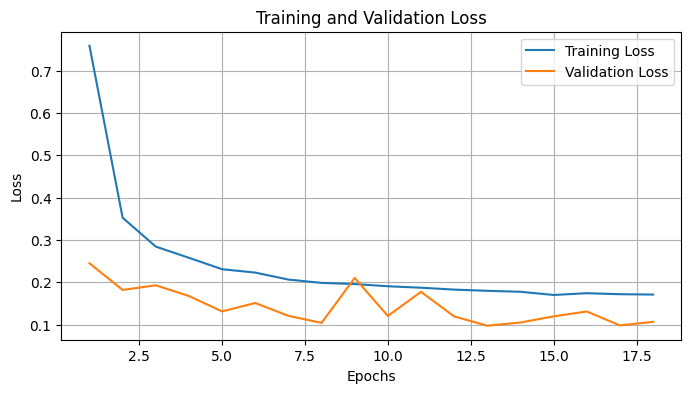

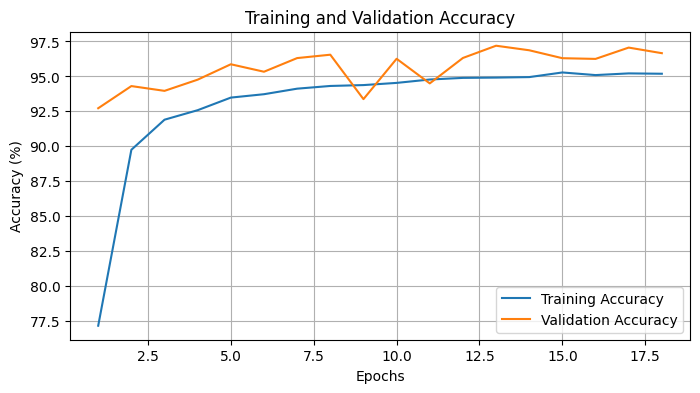

In [7]:

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(range(1, len(val_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(range(1, len(val_losses)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_losses)+1), val_accuracies, label='Validation Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Test the performance of the trained model for test data

In [8]:
# Testing load the model with best validation from checkpoint
model.load_state_dict(torch.load("checkpoint.pth",weights_only=True))
model.to(device)
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0434, Test Accuracy: 98.63%


Visualize the results for a Test batch

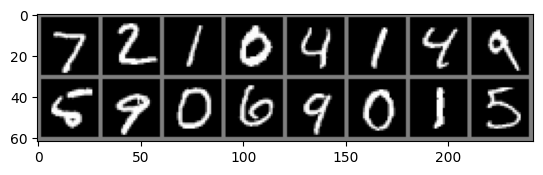

Ground Truth:     7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5
Predicted Val:    7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5


In [10]:
# Get a batch of test data
no_of_samples = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:no_of_samples]))
print('Ground Truth:    ', ' '.join(f'{labels[j]}' for j in range(no_of_samples)))

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted Val:   ', ' '.join(f'{predicted[j].item()}' for j in range(no_of_samples)))


In [12]:
!pip install torchinfo

In [15]:
from torchinfo import summary
batch_size = 64
summary(model, input_size=(batch_size, 3, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 6, 28, 28]           456
├─BatchNorm2d: 1-2                       [64, 6, 28, 28]           12
├─AvgPool2d: 1-3                         [64, 6, 14, 14]           --
├─Conv2d: 1-4                            [64, 16, 10, 10]          2,416
├─BatchNorm2d: 1-5                       [64, 16, 10, 10]          32
├─AvgPool2d: 1-6                         [64, 16, 5, 5]            --
├─Linear: 1-7                            [64, 120]                 48,120
├─BatchNorm1d: 1-8                       [64, 120]                 240
├─Dropout: 1-9                           [64, 120]                 --
├─Linear: 1-10                           [64, 84]                  10,164
├─BatchNorm1d: 1-11                      [64, 84]                  168
├─Dropout: 1-12                          [64, 84]                  --
├